In [1]:
from __future__ import print_function 
import numpy as np
import torch
import torch.autograd as ag
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
import MNISTtools 
import torch.nn as nn
import torch.nn.functional as F
from math import exp
import matplotlib as pyplot 
import torchvision.datasets as dset
import matplotlib.pyplot as plt
#########################Load and reshape image###############################

def normalize_MNIST_images(x,imgw,imgh,channels,samples):
    x = x.astype(np.float64)
    x = (2*x - np.max(x))/np.max(x)
    x = x.reshape(imgw,imgh,channels,samples)
    x = np.moveaxis(x,[0,1,2,3],[2,3,1,0])  #Samples,input_channels,imgw,imgh
    return x

class generator(nn.Module):

    def __init__(self):
        super(generator, self).__init__()
        #ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding_value)
        #BatchNorm2d: Applies Batch Normalization over a 4d input that is seen as a mini-batch of 3d inputs
        
        self.deconv1 = nn.ConvTranspose2d(100, 128, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4)
        self.deconv2_bn = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 4, 2, 1)

    #Weights initialized from a zero-centered normal distribution with standard deviation 0.02
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    
    
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [2]:
def load_dataset(batchSize):
    """Load MNIST or CIFAR-10 dataset."""
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    #trainset = dset.CIFAR10(root='./data', train=True, 
    #                      download=True, transform=transform)
    # testset = dset.CIFAR10(root='./data', train=False,
    #                      download=True, transform=transform)
    trainset = dset.MNIST(root='./data', train=True, 
                          download=True, transform=transform)
    testset = dset.MNIST(root='./data', train=False,
                         download=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True, num_workers=2)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=True, num_workers=2)
    return trainLoader, testLoader

trainLoader, testLoader = load_dataset(100)

In [3]:
#GMAN parameters
MnetG = generator()
MnetG.load_state_dict(torch.load('DC1_MNIST_MnetG.pt'))
MnetG.eval()
MnetG.cuda()

netD1 = discriminator()
netD1.load_state_dict(torch.load('DC1_MNIST_MnetD1.pt'))
netD1.eval()
netD1.cuda()

netD2 = discriminator()
netD2.load_state_dict(torch.load('DC1_MNIST_MnetD2.pt'))
netD2.eval()
netD2.cuda()

netD3 = discriminator()
netD3.load_state_dict(torch.load('DC1_MNIST_MnetD3.pt'))
netD3.eval()
netD3.cuda()

netD4 = discriminator()
netD4.load_state_dict(torch.load('DC1_MNIST_MnetD4.pt'))
netD4.eval()
netD4.cuda()

netD5 = discriminator()
netD5.load_state_dict(torch.load('DC1_MNIST_MnetD5.pt'))
netD5.eval()
netD5.cuda()



#GAN parameters
netG = generator()
netG.load_state_dict(torch.load('netG.pt'))
netG.eval()
netG.cuda()

netD = discriminator()
netD.load_state_dict(torch.load('netD.pt'))
netD.eval()
netD.cuda()

discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
)

Result of MNIST with GMAN:


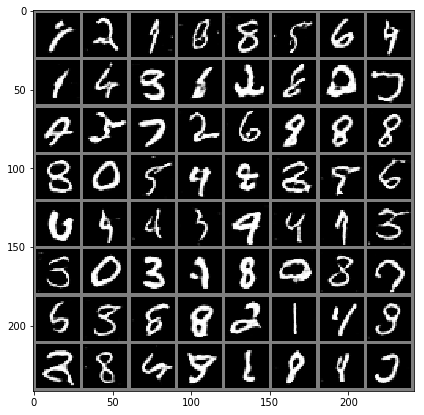

In [27]:
z_ = torch.randn((64,100)).view(-1, 100, 1, 1)

z_ = ag.Variable(z_.cuda(), volatile=True)
test_images = MnetG(z_).cpu()
test_images = test_images.data.numpy()

test_images = torch.from_numpy(test_images).float()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
print("Result of MNIST with GMAN:")
plt.figure(figsize=(14,7))
imshow(torchvision.utils.make_grid(test_images,8))

Result of MNIST with GAN:


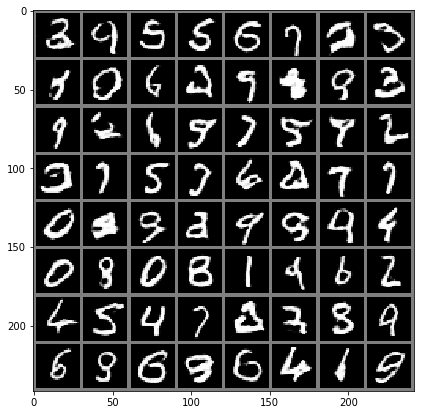

In [25]:
z_ = torch.randn((64,100)).view(-1, 100, 1, 1)

z_ = ag.Variable(z_.cuda(), volatile=True)
test_images = netG(z_).cpu()
test_images = test_images.data.numpy()

test_images = torch.from_numpy(test_images).float()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
print("Result of MNIST with GAN:")
plt.figure(figsize=(14,7))
imshow(torchvision.utils.make_grid(test_images,8))

In [6]:
imgList_gan = []
imgList_gman = []
temp_rs = []
criterion = nn.BCELoss()
Label = ag.Variable(torch.ones(100).cuda())


#Calculate classification error rate for G1 in D2 and G2 in D1
for i in range(1,50):
    fixedNoise = ag.Variable(torch.randn((100, 100)).view(-1, 100, 1, 1).cuda())
    fake_gan = netG(fixedNoise).detach()
    fake_gman = MnetG(fixedNoise).detach()
    output1 = netD(fake_gman.detach()).view(-1)
    #Dgan_Ggman = output1.mean().item()
    errD1 = criterion(output1, Label)   #Classification error of generator of GAN
    outputm1 = netD1(fake_gan.detach()).view(-1)
    outputm2 = netD2(fake_gan.detach()).view(-1)
    outputm3 = netD3(fake_gan.detach()).view(-1)
    outputm4 = netD4(fake_gan.detach()).view(-1)
    outputm5 = netD5(fake_gan.detach()).view(-1)
    output2 = (outputm1+outputm2+outputm3+outputm4+outputm5)/5
    #Dgman_Ggan = output2.mean().item()
    errD2 = criterion(output2, Label) #Classification error of generator of GMAN
    r_s = errD1/errD2
    temp_rs.append(r_s)
    
r_sample = sum(temp_rs)/len(temp_rs)
r_sample = r_sample.cpu().data.numpy()
print('sample rate =', r_sample)
if r_sample < 1:
    print('GAN Win~')
else:
    print('GMAN win~')

sample rate = [13.000223]
GMAN win~


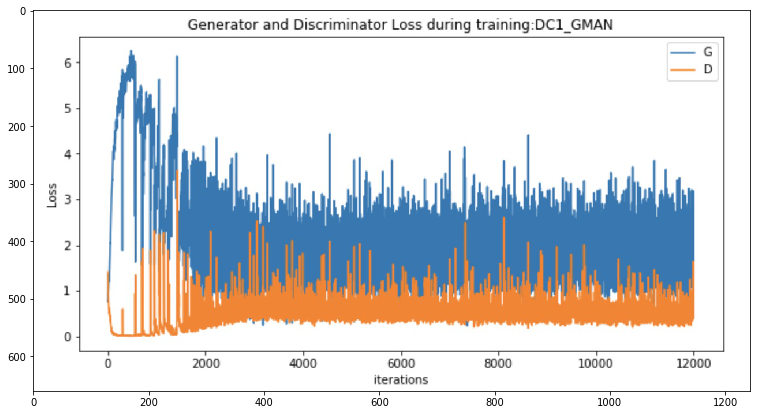

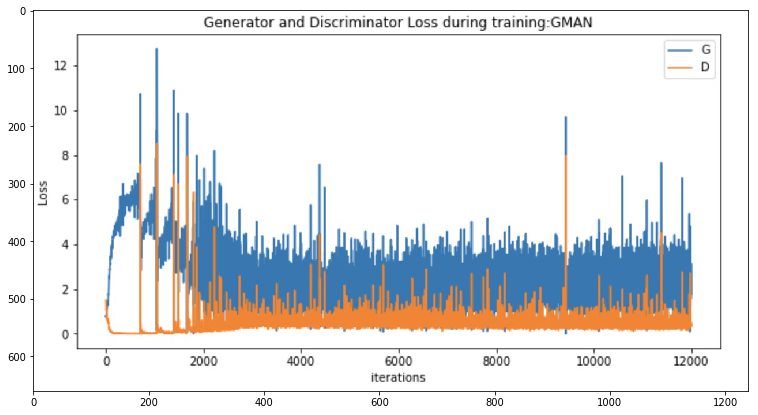

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('DC1_MNIST_GMAN.jpg')
plt.figure(figsize=(14,7))
imgplot = plt.imshow(img)
plt.show()
img=mpimg.imread('DC1_MNIST_GAN.jpg')
plt.figure(figsize=(14,7))
imgplot = plt.imshow(img)
plt.show()